In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.datasets import fetch_openml

from svd import ApproxSVD 

In [3]:
try:
    import fbpca
    HAS_FBPCA = True
except ImportError:
    HAS_FBPCA = False

In [4]:
def load_mnist_subset(n_samples=5000):
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data.astype(np.float32).T[:, :n_samples] / 255.0
    return X  # shape: (784, n_samples)

In [5]:
def explained_variance_ratio(X, X_recon):
    error = np.linalg.norm(X - X_recon, 'fro') ** 2
    total = np.linalg.norm(X, 'fro') ** 2
    return 1 - error / total

In [6]:
def benchmark(method_name, fit_fn):
    start = time.time()
    U, S, Vt, X_recon = fit_fn()
    elapsed = time.time() - start
    evr = explained_variance_ratio(X, X_recon)
    return {
        "method": method_name,
        "time": elapsed,
        "explained_variance": evr,
    }

In [ ]:
def run_benchmarks(X, p=50, g=200):
    results = []

    # Your ApproxSVD
    def run_approx():
        approx_svd = ApproxSVD(n_iter=g, p=p,
                               score_method="cf",
                               debug_mode=False,
                               jobs=8,
                               stored_g = False,
                               use_shared_memory=False,
                               use_heap=False)
        _, U, X_approx = approx_svd.fit(X)
        X_reduced = U.T[:p, :] @ X
        X_recon = U[:, :p] @ X_reduced
        return U, None, None, X_recon
    results.append(benchmark("ApproxSVD", run_approx))

    # sklearn PCA (full SVD)
    def run_pca():
        model = PCA(n_components=p, svd_solver="full")
        model.fit(X.T)
        X_recon = model.inverse_transform(model.transform(X.T)).T
        return model.components_.T, model.singular_values_, None, X_recon
    results.append(benchmark("PCA (full)", run_pca))

    # Incremental PCA
    def run_incpca():
        model = IncrementalPCA(n_components=p, batch_size=1000)
        model.fit(X.T)
        X_recon = model.inverse_transform(model.transform(X.T)).T
        return model.components_.T, None, None, X_recon
    results.append(benchmark("IncrementalPCA", run_incpca))

    # TruncatedSVD (randomized)
    def run_tsvd():
        model = TruncatedSVD(n_components=p)
        X_reduced = model.fit_transform(X.T)
        # Reconstruction: approximate, since TSVD doesn't store mean
        X_recon = (X_reduced @ model.components_).T
        return model.components_.T, None, None, X_recon
    results.append(benchmark("TruncatedSVD", run_tsvd))

    # fbpca (if available)
    if HAS_FBPCA:
        def run_fbpca():
            U, s, Vt = fbpca.pca(X, k=p, raw=True)
            X_recon = (U[:, :p] * s[:p]) @ Vt[:p, :]
            return U, s, Vt, X_recon
        results.append(benchmark("fBPCA", run_fbpca))

    return results

100%|██████████| 2000/2000 [00:03<00:00, 655.11it/s]



Benchmark Results:
ApproxSVD       | Time: 3.11s | Explained Var: 41.37%
PCA (full)      | Time: 0.26s | Explained Var: 98.07%
IncrementalPCA  | Time: 1.50s | Explained Var: 98.04%
TruncatedSVD    | Time: 0.27s | Explained Var: 98.06%


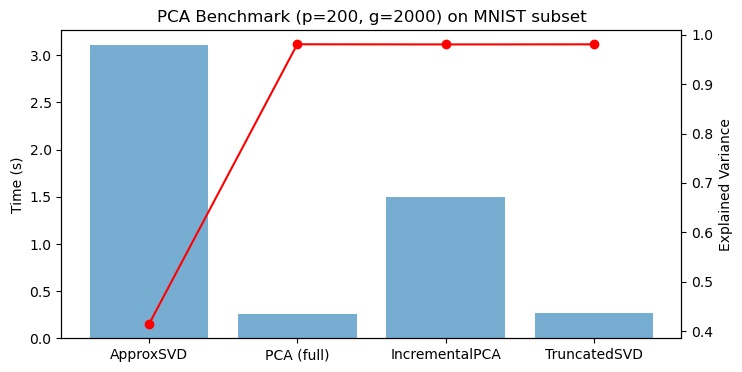

In [14]:
X = load_mnist_subset(n_samples=10000)
p = 200
g = 2000

results = run_benchmarks(X, p=p, g=g)

print("\nBenchmark Results:")
for r in results:
    print(f"{r['method']:15s} | Time: {r['time']:.2f}s | Explained Var: {r['explained_variance']*100:.2f}%")

# Optional: bar plot
methods = [r["method"] for r in results]
times = [r["time"] for r in results]
evrs = [r["explained_variance"] for r in results]

fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

ax1.bar(methods, times, alpha=0.6, label="Time (s)")
ax2.plot(methods, evrs, "o-", color="red", label="Explained Var")

ax1.set_ylabel("Time (s)")
ax2.set_ylabel("Explained Variance")
plt.title(f"PCA Benchmark (p={p}, g={g}) on MNIST subset")
plt.show()